In [3]:
!pip install lightning
!pip install tensorboard
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 555.1/555.1 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import os
import time
import glob
import requests
from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F

import lightning.pytorch as pl
from torchmetrics.functional import accuracy
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

import torchvision
from torchvision import transforms

from PIL import Image

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2, style='whitegrid')

# device_num = 0
# torch.cuda.set_device(device_num)

In [5]:
device = f"cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)

cuda


## 1. Convolution (свёртка) <a id='conv'></a>

Основные гиперпараметры:

* `in_channels` (int) - количество каналов во входном изображении

* `out_channels` (int) - количество каналов после применения свертки (кол-во ядер (фильтров), которые будут применены)

* `kernel_size` (int, tuple) - размер сверточного ядра

* `stride` (int, tuple) - шаг, с которым будет применена свертка. Значение по умолчанию 1

* `padding` (int, tuple) - добавление по краям изображения дополнительных пикселей. Значение по умолчанию 0

* `padding_mode` (string, optional) - принцип заполнения краёв. Значение по умолчанию 'zeros'

`nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=1, padding_mode='zeros')`
 ![](http://deeplearning.net/software/theano/_images/numerical_padding_strides.gif)

 Берем `out_channels` фильтров размера  `in_channels` x `kernel_size` x `kernel_size`. Каждым фильтром 'проходим' по изображению с шагом `stride`, поэлементно умножаем его на область изображения размером `in_channels` x `kernel_size` x `kernel_size`, складываем получившиеся поэлемнетные произведения и записываем это число в результирующий тензор. В итоге получаем `out_channels` выходных тензоров.

 **Интуиция**:

В FC слоях мы соединяли нейрон с каждым нейроном на предыдущем слое. Теперь нейрон соединен только с ограниченной областью выхода предыдущего слоя. Иногда эту область называют *рецептивном полем (receiptive field)* нейрона.

Такое изменение необходимо из-за большой размерности входных данных. Например, если размер входного изображения $3 \cdot 224 \cdot 224$, то каждый нейроне в FC-слое будет содержать $3\cdot 224\cdot 224=150\:528$ параметров, что очень много. При этом мы захотим добавить нелинейности в нашу архитектуру, так что у нас будет несколько таких слоёв.



**Вопрос**

К изображению (3, 224, 224) применяют свертку `nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=2, padding=2)`.

* Какой будет размер выходного изображения?

* Cколько у данного слоя обучаемых параметров?

*Проверяем себя.* Для этого будем использовать библиотеку torchinfo (в прошлом torchsummary). Метод summary данной библиотеки позволяет визуализировать основные характеристики нейронной сети.

In [6]:
! pip3 install torchinfo
from torchinfo import summary

In [7]:
model = nn.Sequential()
model.add_module('conv', nn.Conv2d(in_channels=3, out_channels=64,
                                    kernel_size=5, stride=2, padding=2))

summary(model.to(device), (2, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [2, 64, 112, 112]         --
├─Conv2d: 1-1                            [2, 64, 112, 112]         4,864
Total params: 4,864
Trainable params: 4,864
Non-trainable params: 0
Total mult-adds (M): 122.03
Input size (MB): 1.20
Forward/backward pass size (MB): 12.85
Params size (MB): 0.02
Estimated Total Size (MB): 14.07

In [8]:
3 * 64 * 25 + 64

4864

Посмотрим на то, как применение свёртки с определёнными фильтрами влияет на изображение и как будет меняться картинка в зависимости от фильтра.

In [9]:
# скачиваем изображения
! wget https://upload.wikimedia.org/wikipedia/ru/thumb/2/24/Lenna.png/1920px-Lenna.png
! wget https://miptstats.github.io/images/logo_bottom.png

--2024-09-21 14:55:03--  https://upload.wikimedia.org/wikipedia/ru/thumb/2/24/Lenna.png/1920px-Lenna.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5545662 (5.3M) [image/png]
Saving to: ‘1920px-Lenna.png’

1920px-Lenna.png    100%[===================>]   5.29M  10.2MB/s    in 0.5s    

2024-09-21 14:55:04 (10.2 MB/s) - ‘1920px-Lenna.png’ saved [5545662/5545662]

--2024-09-21 14:55:04--  https://miptstats.github.io/images/logo_bottom.png
Resolving miptstats.github.io (miptstats.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to miptstats.github.io (miptstats.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 212943 (208K) [image/png]
Saving to: ‘logo_bottom.png’

logo_bottom.png     100%[===================>] 20

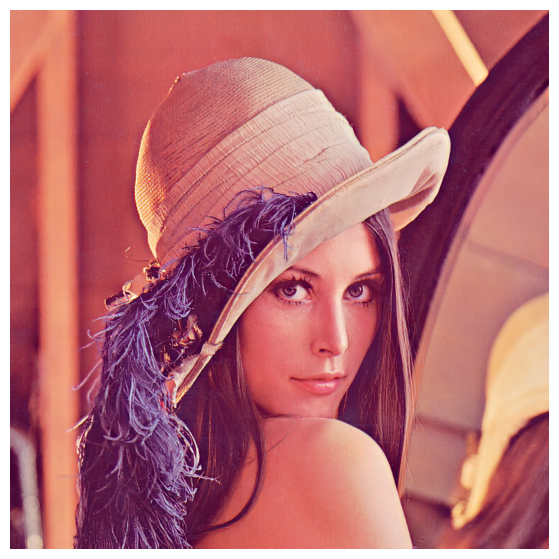

In [10]:
img = Image.open('./1920px-Lenna.png')

plt.figure(figsize=(12,7))
plt.imshow(img)
plt.axis("off");

Функция для инициализации весов слоя.

In [11]:
def init_conv(kernel):
    conv = nn.Conv2d(
        in_channels=1, out_channels=1,
        kernel_size=3, bias=False
    )
    conv.weight = torch.nn.Parameter(
        torch.FloatTensor(kernel),
        requires_grad=False
    )
    return conv

Функция для свертки изображения с одним фильтром.

In [12]:
def convolution(kernel, img, transforms):
    conv = init_conv(kernel)
    img_tensor = transform(img)
    # Добавим батч-размерность
    res = conv(img_tensor.unsqueeze(0))
    # Избавимся от единичных размерностей
    res = res.detach().squeeze()
    # Пиксели имеют значения от 0 до 255
    res = (torch.clip(res, 0, 1) * 255).int()
    return res

Numpy-картинку нужно привести к torch-тензору. Кроме того, для визуализации нам нужно отобразить картинку в черно-белом цвете. Это можно сделать с помощью модуля transforms. Подробнее будет в разделе про аугментации на следующей лекции.

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),   # Переводим массив в торч-тензор
    transforms.Grayscale(),  # Делаем изображение черно-белым
])

Зададим 2 фильтра.

In [14]:
kernel_1 = torch.FloatTensor([[[
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
]]])

kernel_2 = torch.FloatTensor([[[
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
]]])

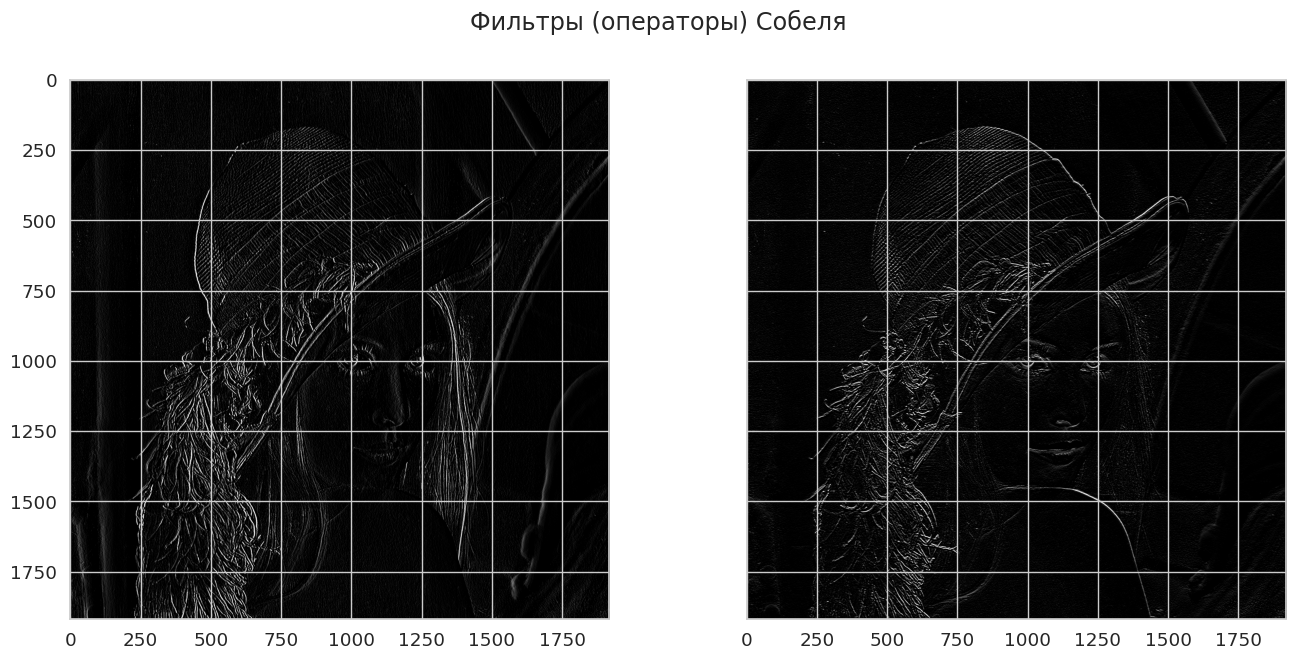

In [15]:
fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(16, 7),
    sharey=True, sharex=True
)

res_images = []
for fig_x, kernel in zip(ax.flatten(), [kernel_1, kernel_2]):
    res = convolution(kernel, img, transform)
    fig_x.imshow(res, cmap='gray')
    res_images.append(res)
plt.suptitle('Фильтры (операторы) Собеля')
plt.show()

Чем более пиксель белый, тем больше его значение. Если присмотреться, то можно заметить, как на первом результате фильтр (ядро) делает более значимыми (белыми) пиксели, соответствующие вертикальным линиям: нос, полоска справа, волосы, а на втором $-$ горизонтальным: брови, губы.

Это как раз согласуется со значениями в фильтрах (ядрах): первый вычисляет перепады значений в пикселях по вертикали, второй $-$ по горизонтали.

С помощью этих фильтров легко прийти к методу выделения границ на изображении: поскольку каждая граница состоит из $x$ и $y$ компоненты, то используем теорему Пифагора и вычислим суммарное значение:

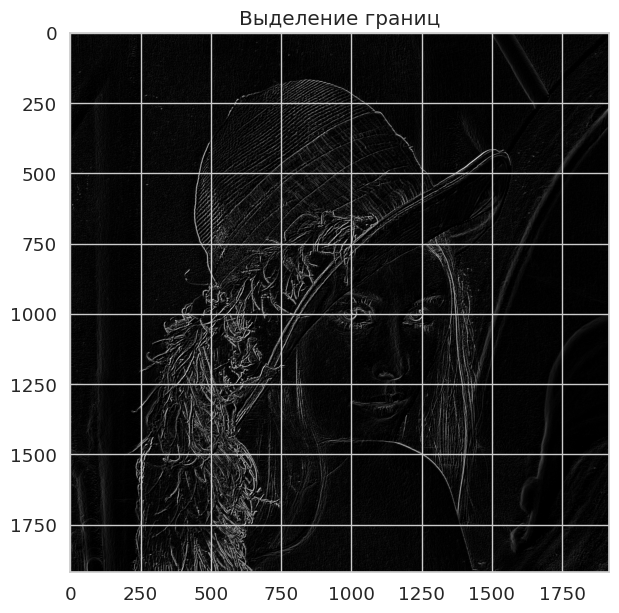

In [16]:
img_sobel = np.sqrt(res_images[0]**2 + res_images[1]**2)

plt.figure(figsize=(12,7))
plt.title('Выделение границ')
plt.imshow(img_sobel, cmap='gray')
plt.show()

Полученный фильтр также [оператором Собеля](https://ru.wikipedia.org/wiki/%D0%9E%D0%BF%D0%B5%D1%80%D0%B0%D1%82%D0%BE%D1%80_%D0%A1%D0%BE%D0%B1%D0%B5%D0%BB%D1%8F). Так, мы посмотрели как работает свертка на примере оператора Собеля.

Давайте задатим ещё несколько фильтров:



In [17]:
some_kernels = [
    torch.FloatTensor([[[[0, 0, 0],
                         [0, 1, 0],
                         [0, 0, 0]]]]),

    torch.FloatTensor([[[[1, 1, 1],
                         [1, 1, 1],
                         [1, 1, 1]]]]) /  10,

    torch.FloatTensor([[[[0, -1,  0],
                        [-1,  5, -1],
                        [0, -1,  0]]]]),

    torch.FloatTensor([[[[-1, -1, -1],
                        [-1,  9, -1],
                        [-1, -1, -1]]]])
]

Загрузим вторую картинку для сравнения и конвертируем в `jpeg`.

In [18]:
img_1 = Image.open("./logo_bottom.png")
bg = Image.new("RGB", img_1.size, (255,255,255))
bg.paste(img_1, img_1)
bg.save("logo_bottom.jpg")
img_1 = Image.open("./logo_bottom.jpg")

tensor([[[[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]]]])


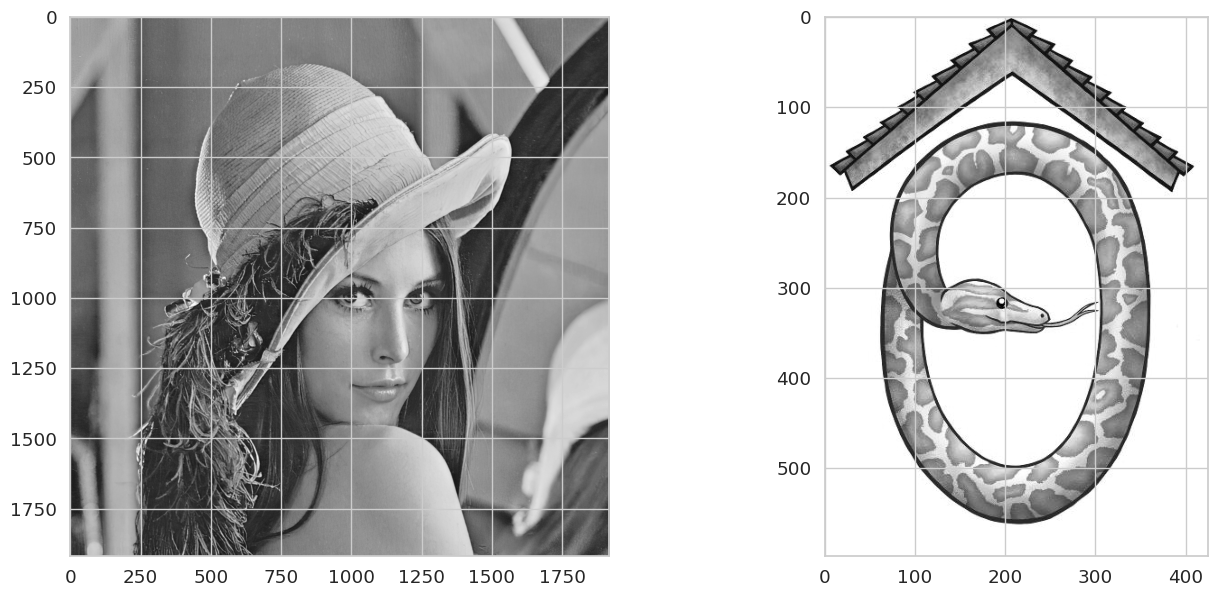


tensor([[[[0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000]]]])


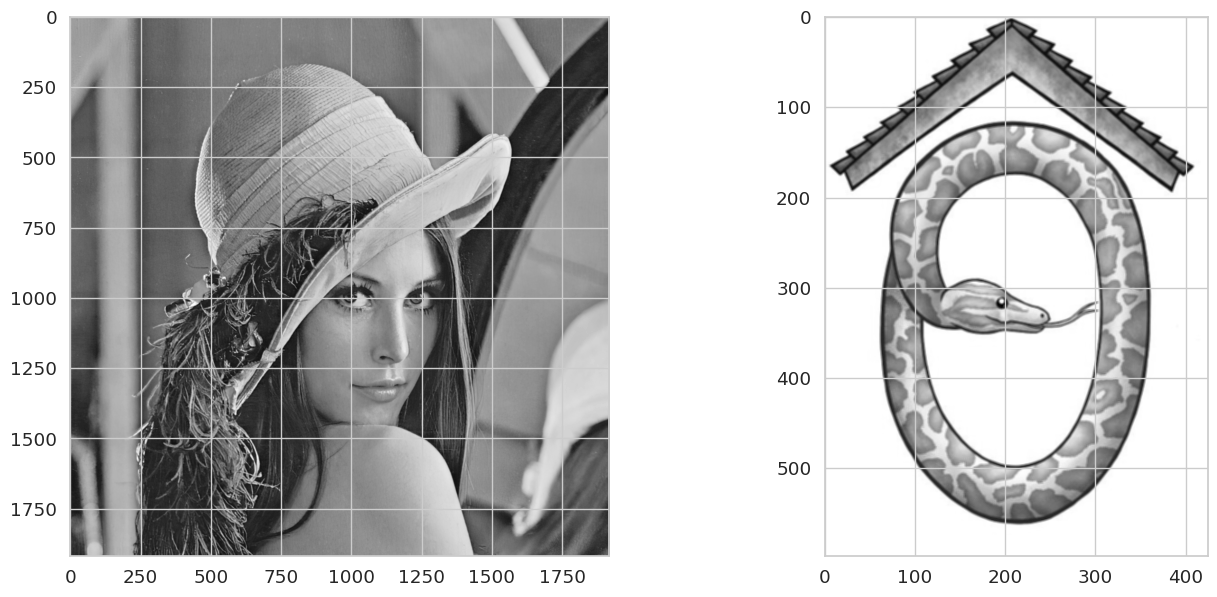


tensor([[[[ 0., -1.,  0.],
          [-1.,  5., -1.],
          [ 0., -1.,  0.]]]])


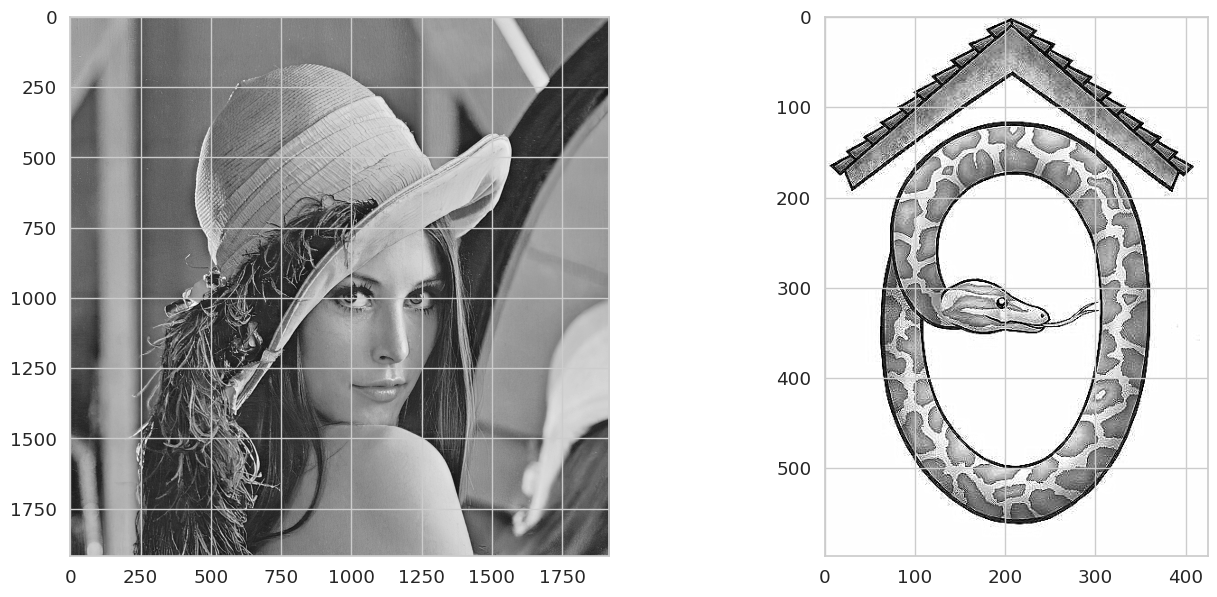


tensor([[[[-1., -1., -1.],
          [-1.,  9., -1.],
          [-1., -1., -1.]]]])


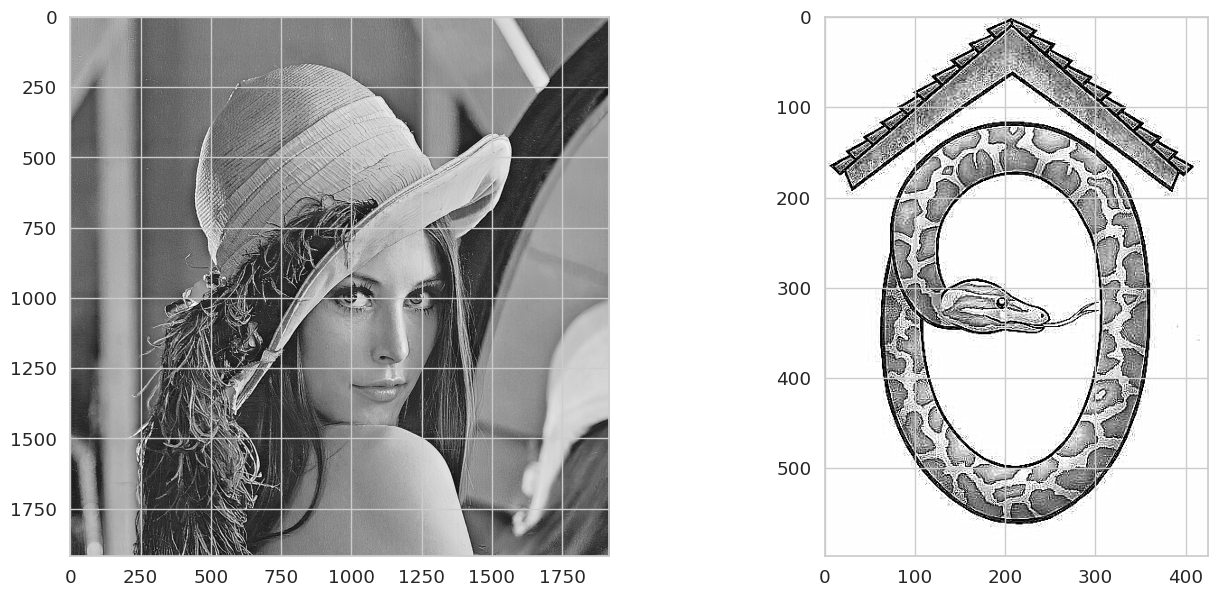

In [19]:
for kernel in some_kernels:
    print(kernel.data)
    plt.figure(figsize=(16, 7))

    plt.subplot(1, 2, 1)
    res = convolution(kernel, img, transform)
    plt.imshow(res, cmap='gray')

    plt.subplot(1, 2, 2)
    res = convolution(kernel, img_1, transform)
    plt.imshow(res, cmap='gray')

    plt.show()
    print()

Какие эффекты дают такие свёртки? Объясните как работает каждая.

**Ответ**

Эти свёртки представляют собой разные ядра фильтров для обработки изображения.

1. Первое ядро просто копирует пиксели, не влияя на соседние значения. Тождественное преобразование.

2. Второй фильтр похож на усреднение, где каждый пиксель заменяется средним значением пикселей в окрестности. Он размывает изображение, делая его более гладким и снижая уровень деталей.

3. Третий фильтр усиливает края и повышает резкость изображения. Он выделяет контуры объектов и делает их более заметными, сохраняя при этом общую структуру изображения.

4. Четвертый фильтр более агрессивный по резкости. Он значительно увеличивает контраст между пикселями и выделяет более резкие грани.

## 3. Pooling <a id='pooling'></a>

Основные гиперпараметры:

* `kernel_size` (int, tuple) - размер ядра

* `stride` (int, tuple) - шаг, с которым будет применен pooling. Значение по умолчанию `kernel_size`

* `padding` (int, tuple) - добавление по краям изображения нулей

Основные виды pooling-ов:
* `MaxPooling` &mdash; берется максимум элементов,
* `AveragePooling` &mdash; берется среднее элементов.

![](https://sun9-10.userapi.com/c854016/v854016674/22a457/mpE8Idra-5Y.jpg)

**Интуиция:**

* cнижаем размерность изображения и, как следствие, вычислительную сложность;

* увеличиваем рецептивное поле на входном изображении для нейронов следующих сверточных слоев.

При этом многие исследователи ставят под сомнение эффективность pooling слоёв. Например, в статье [Striving for Simplicity: The All Convolutional Net](https://arxiv.org/abs/1412.6806) предлагается заменить его на свертки с большим stride-ом. Также считается, что отсутствие pooling слоёв хорошо сказывается на обучении генеративных моделей, но споры ещё ведутся: [FCC-GAN: A Fully Connected and Convolutional Net
Architecture for GANs](https://arxiv.org/pdf/1905.02417.pdf)


**Вопрос:** сколько обучаемых параметров у pooling слоя?

Применим наши знания для решения конкретной задачи.

##  4. CIFAR10

Датасет состоит из 60k картинок 32х32х3.

50k &mdash; обучающая выборка, 10k &mdash; тестовая.

10 классов: 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'.

 ![](https://sun9-72.userapi.com/c857216/v857216523/12dbca/vdSCet5LS_0.jpg)

Загружаем датасет.

In [20]:
# Загрузим часть данных для обучения
dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
# Разделим выборку на обучение и валидацию
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [40000, 10000])

# Загрузим тестеовую часть данных
test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:05<00:00, 30871669.67it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Инициализируем генераторы батчей:

In [21]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen   = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=True)
test_batch_gen  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

Пайплайн обучения.

### 4.1. Baseline

Начнем с простой линейной модели, рассмотренной на прошлом семинаре по нейросетям:

In [22]:
class MySimpleModel(nn.Module):
    def __init__(self):
        '''
        Здесь объявляем все слои, которые будем использовать
        '''

        super(MySimpleModel, self).__init__()
        # входное количество признаков = высота * ширина * кол-во каналов картинки
        # сейчас 64 нейрона в первом слое
        self.linear1 = nn.Linear(3 * 32 * 32, 64)
        # 10 нейронов во втором слое
        self.linear2 = nn.Linear(64, 10)  # логиты (logits) для 10 классов

    def forward(self, x):
        '''
        Здесь пишем в коде, в каком порядке какой слой будет применяться
        '''

        x = self.linear1(nn.Flatten()(x))
        x = self.linear2(nn.ReLU()(x))
        return x

Применим ее к нашим данным $-$ картинками из CIFAR10:

In [23]:
class MySimpleModelLightning(pl.LightningModule):
    def __init__(self, lr=0.01, n_classes=10, model_=MySimpleModel()):
        super().__init__()

        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr
        self.n_classes = n_classes
        self.save_hyperparameters() # сохраним гиперпараметры
        self.model = model_

    def forward(self, x):
        '''Forward pass'''
        return self.model(x)

    def training_step(self, batch, batch_idx):
        '''Возвращает лосс с 1 шага обучения по батчу'''
        _, loss, acc = self.__get_preds_loss_accuracy(batch)

        # Логируем лосс и метрику
        self.log('train_loss', loss)
        self.log('train_accuracy', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        '''Используется для логирования метрик'''
        preds, loss, acc = self.__get_preds_loss_accuracy(batch)

        # Логируем лосс и метрику
        self.log('val_loss', loss)
        self.log('val_accuracy', acc)

        # Возвращаем предсказания, чтобы использовать их в callback
        return preds

    def configure_optimizers(self):
        '''определяет оптимизатор модели'''
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def __get_preds_loss_accuracy(self, batch):
        '''вспомогательная функция для шага обучения / валидации'''
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.criterion(logits, y)
        acc = accuracy(preds, y, 'multiclass', num_classes=self.n_classes)
        return preds, loss, acc

In [24]:
tb_logger = pl_loggers.TensorBoardLogger(save_dir="lightning_logs/")

# инициализируем модель
simple_model = MySimpleModelLightning()

# Создаем чекпоинтер
checkpoint_callback = ModelCheckpoint(monitor='val_accuracy', mode='max')
# Создаем коллбек для остановки обучения в случае отсутствия улучшений:
early_stopping = EarlyStopping('val_loss')

trainer = pl.Trainer(
    logger=tb_logger,
    callbacks=[checkpoint_callback,
               early_stopping,],
    accelerator="gpu",
    max_epochs=30)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model_' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model_'])`.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [25]:
trainer.fit(simple_model, train_batch_gen, val_batch_gen)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | model     | MySimpleModel    | 197 K  | train
-------------------------------------------------------
197 K     Trainable params
0         Non-trainable params
197 K     Total params
0.789     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | model     | MySimpleModel    | 197 K  | train
-------------------------------------------------------
197 K     Trainable params
0         Non-trainable params
197 K     Total params
0.789     Total 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [33]:
#%reload_ext tensorboard
#%tensorboard --logdir=lightning_logs/

### 4.2. Свёрточная нейросеть <a id=cnn> </a>

*Свёрточная нейросеть / Convolutional Neural Network / CNN* &mdash; это многослойная нейросеть, имеющая в своей архитектуре свёрточные слои / Conv Layers и pooling-слои / Pool Layers.

Простые свёрточные нейросети для классификации, почти всегда строятся по следующему правилу:

$INPUT \to [[CONV -> RELU]^N \to POOL?]^M \to [FC -> RELU]^K \to FC$

"?" обозначает опциональные слои.

![](https://sun9-64.userapi.com/c856028/v856028087/1eae7b/GrKeqELsvWM.jpg)

Подробнее:

1. Входной слой (batch картинок HxWxC)

2.  $M$  блоков ($M  \ge  0$) из свёрток и pooling-ов. Все эти  $M$  блоков вместе называют *feature extractor* свёрточной нейросети, потому что эта часть сети отвечает непосредственно за формирование новых, более сложных признаков, поверх тех, которые подаются.

  При этом лучше использовать несколько сверток с маленьким рецептивным полем, чем одну свертку с большим рецептивным полем.

3.  $K$  штук FullyConnected-слоёв с активациями. Эту часть из  $K$  FC-слоёв называют *classificator*, поскольку эти слои отвечают непосредственно за предсказание нужно класса.

  *Замечание*:  Pooling layer можно пропустить и не включать в архитектуру, но при этом он снижает размерность, а следовательно и вычислительную сложность, а также помогает бороться с переобучением

**Пример, почему 3 свертки 3х3 экономнее по памяти, чем одна свертка 7x7:**

Предположим, что входное изображение имеет $C$ каналов, и что количество фильтров в сверточных слоях тоже равно $C$.

1. **[CONV((3, 3)) -> RELU]^3**

  Количество параметров: $3(C(C*3*3)) = 27C^2$
    
  Рецептивное поле первой свертки на входном изображении: $3\times3$
    
  Рецептивное поле второй свертки на выходе первой свертки: $3\times3$, и, следовательно, $5\times5$ на входном изображении.
    
  Аналогично рецептивное поле третьей свертки, а значит и всего блокаБ на входном изображении: $7\times7$.
    

2. **[CONV((7, 7)) -> RELU]^1**

  Количество параметров: $C(C*7*7) = 49C^2$
    
  Рецептивное поле на входном изображении: $7\times7$
    
**Вывод:** Первый вариант формирует более сложные признаки из-за нелинейностей, при этом имеет меньше параметров и такое же рецептивное поле на входном изображении.



Также нужно не забывать о пользе `Dropout` и `BatchNorm`:

* `Dropout` позволяет бороться с переобучением, можно интерпретировать как обучение ансамбля моделей.
* `BatchNorm` нормирует данные, делает веса на более поздних слоях менее чувствительными к изменениям весов на начальных слоях. Таким образом `BatchNorm` позволяет сделать нейросеть более стабильной при изменении распределения входных данных.

**Вопрос**: посмотрите на следующую нейросеть и укажите на некорректные шаги в реализации.


In [ ]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(3, 2048, kernel_size=5, stride=2, padding=3))
model.add_module('mp1', nn.MaxPool2d(7))

model.add_module('conv2', nn.Conv2d(2048, 64, kernel_size=3))
model.add_module('mp2', nn.MaxPool2d(2))

model.add_module('bn1', nn.BatchNorm2d(64))
model.add_module('dp1', nn.Dropout(0.5))
model.add_module('relu1', nn.ReLU())

model.add_module('conv3', nn.Conv2d(64, 128, kernel_size=(20, 20)))
model.add_module('mp3', nn.MaxPool2d(2))

model.add_module('conv4', nn.Conv2d(128, 256, kernel_size=(20, 20)))

model.add_module('flatten', nn.Flatten())
model.add_module('fc1', nn.Linear(1024, 512))
model.add_module('fc2', nn.Linear(512, 10))
model.add_module('dp2', nn.Dropout(0.05))

> Подсказка:

*(нужно дважды кликнуть на ячейку)*
<style>
div.input {
    
* нет активаций после сверток (свертка по своей сути - линейное преобразование и активации нужны, чтобы добавить нелинейность)

* слишком много выходных каналов в `conv1`. Увеличили число параметров слишком сильно: мы потратим гораздо больше времени на обучение при этом получив много повторяющихся сверток

* теряем слишком много информации в `mp1`, размер ядра нужно уменьшить

* теряем слишком много информации в `dp1`

* слишком большой `kernel_size` в `conv3` и `conv4`, этот код не сможет скомпилироваться, потому что размер изображения будет меньше, чем `kernel_size`

* два линейных слоя подряд `fc1` и `fc2` без активации между ними можно заменить одним синейным слоем

* `droupout` в конце просто зануляет часть выходов к лоссу, а не выключает связи между нейронами. Тем самым мы теряем уже выученную информацию, а не боремся с переобучением.
display:none;
}
</style>

Исправим все ошибки и обучим полученную сверточную сеть.



In [27]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3)
        self.mp1 = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(32)
        self.droupout1 = nn.Dropout(0.3)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(32, 64, 3)
        self.mp2 = nn.MaxPool2d(2)
        self.bn2 = nn.BatchNorm2d(64)
        self.droupout2 = nn.Dropout(0.3)
        self.relu2 = nn.ReLU()

        self.flatten = nn.Flatten()
        self.fc3 = nn.Linear(2304, 512)
        self.droupout3 = nn.Dropout(0.3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(512, 10)

    def forward(self, x):
        layer1 = self.mp1(self.conv1(x))
        layer1 = self.relu1(self.droupout1(self.bn1(layer1)))

        layer2 = self.mp2(self.conv2(layer1))
        layer2 = self.relu2(self.droupout2(self.bn2(layer2)))

        out = self.flatten(layer2)
        out = self.relu3(self.droupout3(self.fc3(out)))
        out = self.fc4(out)
        return out

In [28]:
tb_logger = pl_loggers.TensorBoardLogger(save_dir="lightning_logs/cnn", )

# инициализируем модель
simple_model = MySimpleModelLightning(model_=SimpleConvNet())

# Создаем чекпоинтер
checkpoint_callback = ModelCheckpoint(monitor='val_accuracy', mode='max')
# Создаем коллбек для остановки обучения в случае отсутствия улучшений:
early_stopping = EarlyStopping('val_loss')

trainer = pl.Trainer(
    logger=tb_logger,
    callbacks=[checkpoint_callback,
               early_stopping,],
    accelerator="gpu",
    max_epochs=30)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model_' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model_'])`.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [29]:
trainer.fit(simple_model, train_batch_gen, val_batch_gen)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | model     | SimpleConvNet    | 1.2 M  | train
-------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.819     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | model     | SimpleConvNet    | 1.2 M  | train
-------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.819     Total 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [32]:
#%reload_ext tensorboard
#%tensorboard --logdir=lightning_logs/cnn

> Сравните полученное качество с тем, что мы получили ранее для не сверточной сетки.

**Accuracy:**

CNN = 0.6272

FCNN = 0.1741

Т.о. делаем вывод, что сверточная нейронная сеть смогла заметить более тонкие паттерны и она хорошо подходит для задачи классификации изображений.